In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from plotting import draw_1d, create_df
from plotting import var_kw, process_kw, nllscan_kw
import oyaml as yaml
import pandas as pd
import numpy as np
import dftools
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import dftools
import scipy
mpl.use('pdf')
plt.style.use('cms')

In [4]:
def custom_cms_label(ax, label, lumi=35.9, energy=13):
    ax.text(
        0, 1, r'$\mathbf{CMS}\ \mathit{'+label+'}$',
        ha='left', va='bottom', transform=ax.transAxes,
    )
    ax.text(
        1, 1, r'${:.0f}\ \mathrm{{fb}}^{{-1}}$ ({:.0f} TeV)'.format(lumi, energy),
        ha='right', va='bottom', transform=ax.transAxes,
    )

[b'limit',
 b'limitErr',
 b'mh',
 b'syst',
 b'iToy',
 b'iSeed',
 b'iChannel',
 b't_cpu',
 b't_real',
 b'quantileExpected',
 b'muV',
 b'deltaNLL']

[array([0.34337951, 1.63342261])]

[('0.7', '0.6')]

1_{-0.7}^{+0.6} {}^{\circ}$
SM vs PS significance is $0^+ \mathrm{vs}\ 0^- =$\ 1.22$\sigma$


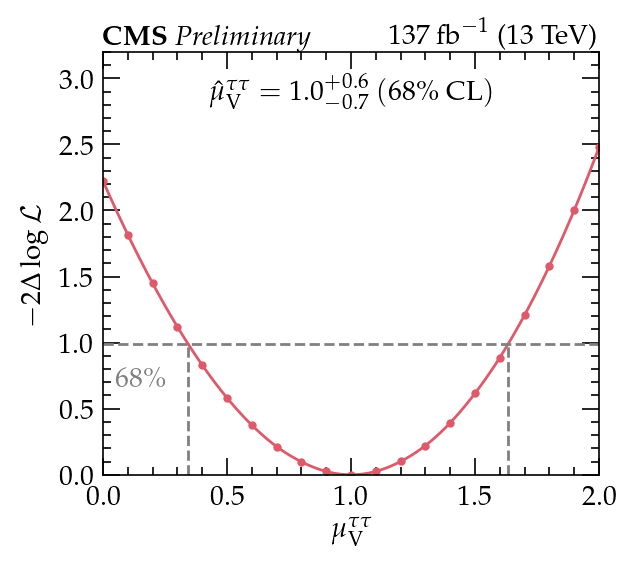

In [62]:
# combined scan
add_significance = False
#add = ""
add = "_mergeXbins"
parameter = "muV"
boundaries = []
if parameter == "alpha":
    boundaries = [(-90,0), (0,90)]
elif parameter in ["muggH", "muV"]:
    boundaries = [(0,1), (1,2)]
with mpl.backends.backend_pdf.PdfPages(f"plots/{parameter}_cmb_01052020{add}_postFirstImpacts.pdf", keep_empty=False,) as pdf:
    fig, ax = plt.subplots(
        figsize=(3.2, 2.8), dpi=200,
    )
    
    test = (
        #"/vols/build/cms/akd116/newest/Combine/Decays/CMSSW_10_2_13/src/"
        #"CombineHarvester/HTTSMCPDecays18/output/"
        #f"01052020{add}/cmb/125/higgsCombine.alpha.MultiDimFit.mH125.root"
        
        #"30042020_mergeXbins/cmb/125/higgsCombine.alpha.MultiDimFit.mH125.root"
        #"/vols/build/cms/dw515/CPdecay/CMSSW_10_2_13/src/"
        #"CombineHarvester/HTTSMCPDecays18/alpha_cmb.root"
        "~/public_html/CP/202005_May/06_NewFitsPostFirstImpacts/"
        f"higgsCombine.{parameter}.MultiDimFit.mH125.root"
    )
    f = uproot.open(test)["limit"]
    display(f.keys())
    df = f.pandas.df([parameter,"deltaNLL","quantileExpected"],
        namedecode="utf-8")
    df = df.query("quantileExpected > -0.5")
    df = df.loc[~df.duplicated(),:]
    df = df.sort_values(by=parameter)
    
    scan_kw = dict(color=nllscan_kw["tt"][0][2])
    # either specify sigma or do using percent level
    #nsigs = [1,2]
    pc_level = [0.68,]# 0.95]
    nsigs = []
    for pc in pc_level:
        nsigs.append(scipy.stats.norm.ppf((1+pc)/2))
    results = dftools.draw.nllscan(
        df[parameter], 2*df["deltaNLL"], ax=ax, nsigs=nsigs, 
        left_bracket=boundaries[0], right_bracket=boundaries[1],
        marker_kw=scan_kw, spline_kw=scan_kw,
    )
    custom_cms_label(ax, "Preliminary", lumi=137)
    if parameter == "alpha":
        ax.set_xticks([-90, -45, 0, 45, 90])
        ax.set_xlim(-90., 90)
        ax.set_ylim(0., None)
        
        #ax.text(-85, 1.01, r'$1\sigma$', ha='left', va='bottom', color='gray')
        #ax.text(-85, 4.01, r'$2\sigma$', ha='left', va='bottom', color='gray')
        ax.text(-85, 0.61, r'$68\%$', ha='left', va='bottom', color='gray')
        ax.text(-85, 3.41, r'$95\%$', ha='left', va='bottom', color='gray')
        #ax.text(-85, 1.01, r'$68\%$', ha='left', va='bottom', color='gray')
        #ax.text(-85, 4.01, r'$95\%$', ha='left', va='bottom', color='gray')
    else:
        ax.set_xlim(0, 2)
        ax.set_ylim(0., None)
        ax.text(0.05, 0.61, r'$68\%$', ha='left', va='bottom', color='gray')
        #ax.text(0.05, 3.41, r'$95\%$', ha='left', va='bottom', color='gray')
    
    bestfit = results.query("nsig == 0.")["xval"].values
    #result = np.abs(results.query("abs(nsig) == 1.")["xval"].values)
    #result_2s = np.abs(results.query("abs(nsig) == 2.")["xval"].values)
    result_values = []
    label_strings = []
    for nsig in nsigs:
        result_values.append(np.abs(results.query(f"abs(nsig) == {nsig}")["xval"].values))
    display(result_values)
    for result in result_values:
        unc_hi = result[1] - bestfit[0]
        unc_lo = bestfit[0] - result[0]
        hi_string = f"{unc_hi:.1f}"
        lo_string = f"{unc_lo:.1f}"
        string = (lo_string, hi_string)
        label_strings.append(string)
    display(label_strings)
    #if hi_string == lo_string:
    #    
    #    full_string = f"{bestfit[0]:.0f} \\pm {hi_string}\\ {{}}^{{\circ}}$"
    #else:
    full_strings = []
    for idx, string in enumerate(label_strings):
        if string[0] == string[1]:
            
            full_string = f"{bestfit[0]:.1f} \\pm {string[0]}\\ "
        else:
            full_string = (f"{bestfit[0]:.1f}_{{-{string[0]}}}^{{+{string[1]}}}\\ ")
        full_strings.append(full_string)
        
        if parameter == "alpha":
            result_label = (
                r"$\hat{\phi}_{\tau\tau} = " + full_string + "\\ {{}}^{{\circ}}"
            )
        elif parameter == "muggH":
            result_label = (
                r"$\hat{\mu}_{gg\mathrm{H}}^{\tau\tau} = " + full_string
            )
        elif parameter == "muV":
            result_label = (
                r"$\hat{\mu}_{\mathrm{V}}^{\tau\tau} = " + full_string
            )
            
        if idx == 0:
            ax.text(
                0.5, 0.85, 
                result_label + r"(68\%\ \mathrm{CL})$",
                ha='center', va='bottom',
                transform=ax.transAxes, 
            )
        #elif idx == 1:
        #    ax.text(
        #        0.5, 0.75, 
        #        result_label + r"(95\%\ \mathrm{CL})$",
        #        ha='center', va='bottom',
        #        transform=ax.transAxes, 
        #    )
        
        print(f"{bestfit[0]:.0f}_{{-{string[0]}}}^{{+{string[1]}}} {{}}^{{\circ}}$")
    
    # Add significance of SM vs PS discrimination
    significance = np.sqrt(
        scipy.stats.chi2.ppf(
            scipy.stats.chi2.cdf(
                max(2*df["deltaNLL"])-bestfit,
            1),
        1)
    )[0]
    sig_label = r"$0^+ \mathrm{vs}\ 0^- =$\ "+f"{significance:.2f}$\sigma$"
    print(f"SM vs PS significance is {sig_label}")
    if add_significance:
        ax.text(
            0.5, 0.65,
            sig_label,
            ha='center', va='bottom',
            transform=ax.transAxes,
        )
    ax.set_ylim(0, 5.2)

    if parameter == "alpha":
        ax.set_xlabel(r"$\phi_{\tau\tau} (\mathrm{degrees})$")
    elif parameter == "muggH":
        ax.set_xlabel(r"$\mu_{gg\mathrm{H}}^{\tau\tau}$")
    elif parameter == "muV":
        ax.set_xlabel(r"$\mu_{\mathrm{V}}^{\tau\tau}$")
        ax.set_ylim(0, 3.2)
    ax.set_ylabel(r"$-2\Delta\log\mathcal{L}$")
    pdf.savefig(fig, bbox_inches='tight')
pass

SM vs PS significance for bin 0 is $0^+ \mathrm{vs}\ 0^- =$\ 1.66$\sigma$
SM vs PS significance for bin 3 is $0^+ \mathrm{vs}\ 0^- =$\ 1.02$\sigma$
SM vs PS significance for bin 4 is $0^+ \mathrm{vs}\ 0^- =$\ 0.29$\sigma$
SM vs PS significance for bin 5 is $0^+ \mathrm{vs}\ 0^- =$\ 0.49$\sigma$
SM vs PS significance for bin 6 is $0^+ \mathrm{vs}\ 0^- =$\ 0.17$\sigma$
SM vs PS significance for bin 7 is $0^+ \mathrm{vs}\ 0^- =$\ 0.99$\sigma$
SM vs PS significance for bin 8 is $0^+ \mathrm{vs}\ 0^- =$\ 0.39$\sigma$
SM vs PS significance for bin 9 is $0^+ \mathrm{vs}\ 0^- =$\ 0.37$\sigma$
SM vs PS significance for bin 10 is $0^+ \mathrm{vs}\ 0^- =$\ 0.22$\sigma$
SM vs PS significance for bin 11 is $0^+ \mathrm{vs}\ 0^- =$\ 0.11$\sigma$


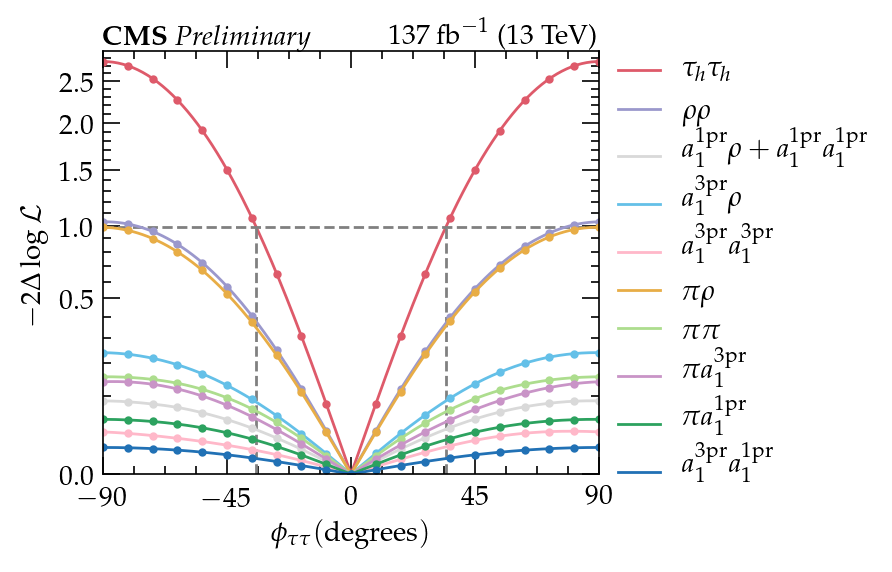

In [36]:
# split by channel and subcategories
channel = "tt"
with mpl.backends.backend_pdf.PdfPages(f"plots/alpha_{channel}_split_01052020_mergeXbins.pdf", keep_empty=False,) as pdf:
    fig, ax = plt.subplots(
        figsize=(3.2, 2.8), dpi=200,
    )
    
    if channel == "tt":
        bins = [0] + list(np.arange(3, 12, 1))
    elif channel == "mt":
        bins = [0] + list(np.arange(3, 7, 1))
    labels = []
    for (category, bin_) in zip([f"htt_{channel}"] + [f"htt_{channel}_{x}_13TeV" for x in list(np.arange(3, 12, 1))], bins):
        scan_result = (
            #"/vols/build/cms/dw515/CPdecay/CMSSW_10_2_13/src/"
            #"CombineHarvester/HTTSMCPDecays18/output/"
            "/vols/build/cms/akd116/newest/Combine/Decays/CMSSW_10_2_13/src/"
            "CombineHarvester/HTTSMCPDecays18/output/"
            f"01052020_mergeXbins/{category}/125/higgsCombine.alpha.MultiDimFit.mH125.root"
        )
        f = uproot.open(scan_result)["limit"]
        df = f.pandas.df(["alpha","deltaNLL","quantileExpected"],
            namedecode="utf-8")
        df = df.query("quantileExpected > -0.5")
        df = df.loc[~df.duplicated(),:]
        df = df.sort_values(by="alpha")
        
        xvalues = df["alpha"]
        yvalues = 2*df["deltaNLL"]
        
        if bin_ == 0:
            nsigmas = [scipy.stats.norm.ppf((1-(1-0.68)/2))]
        else:
            nsigmas = []
        
        scan_kw = dict(color=nllscan_kw[channel][bin_][2],)

        results = dftools.draw.nllscan(
            xvalues, yvalues, ax=ax, nsigs=nsigmas, 
            left_bracket=(-90,0), right_bracket=(0,90),
            marker_kw=scan_kw, spline_kw=scan_kw,
        )
        labels.append(nllscan_kw[channel][bin_][0])
        
        # print significance of each category
        significance = np.sqrt(
            scipy.stats.chi2.ppf(
                scipy.stats.chi2.cdf(
                    max(yvalues),
                1),
            1)
        )
        sig_label = r"$0^+ \mathrm{vs}\ 0^- =$\ "+f"{significance:.2f}$\sigma$"
        print(f"SM vs PS significance for bin {bin_} is {sig_label}")
    custom_cms_label(ax, "Preliminary", lumi=137)
    ax.set_xticks([-90, -45, 0, 45, 90])
    ax.set_xlim(-90., 90)
    ax.set_ylim(0., None)
    
    #ax.text(-85, 1.01, r'$68\%$', ha='left', va='bottom', color='gray')
    
    full_handles, full_labels = ax.get_legend_handles_labels()
    handles = [x for idx, x in enumerate(full_handles) if "Spline" in full_labels[idx]]
    ax.legend(handles, labels, bbox_to_anchor=(1, 1.03), labelspacing=0.3, borderpad=0.2)
    ax.set_xlabel(r"$\phi_{\tau\tau} (\mathrm{degrees})$")
    
    ax.set_yscale('function', functions=(lambda x: np.maximum(x, 0)**0.5, lambda x: x**2))
    ax.set_ylabel(r"$-2\Delta\log\mathcal{L}$")
    
    pdf.savefig(fig, bbox_inches='tight')
    pass

SM vs PS significance for year combined is $0^+ \mathrm{vs}\ 0^- =$\ 2.18$\sigma$
SM vs PS significance for year 2016 is $0^+ \mathrm{vs}\ 0^- =$\ 1.09$\sigma$
SM vs PS significance for year 2017 is $0^+ \mathrm{vs}\ 0^- =$\ 1.13$\sigma$
SM vs PS significance for year 2018 is $0^+ \mathrm{vs}\ 0^- =$\ 1.52$\sigma$


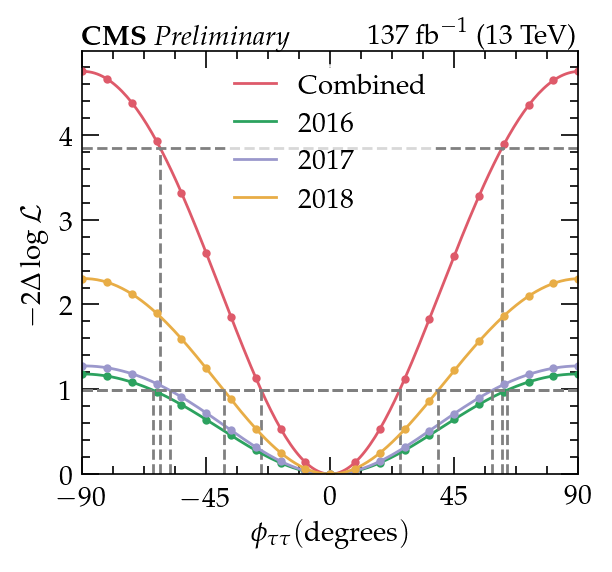

In [56]:
# split by years
channel = "years"
with mpl.backends.backend_pdf.PdfPages(f"plots/alpha_split_years_01052020_mergeXbins.pdf", keep_empty=False,) as pdf:
    fig, ax = plt.subplots(
        figsize=(3.2, 2.8), dpi=200,
    )
    
    labels = []
    significances = []
    for idx, category in enumerate(["cmb","htt_2016", "htt_2017", "htt_2018"]):
        scan_result = (
            #"/vols/build/cms/dw515/CPdecay/CMSSW_10_2_13/src/"
            #"CombineHarvester/HTTSMCPDecays18/output/"
            "/vols/build/cms/akd116/newest/Combine/Decays/CMSSW_10_2_13/src/"
            "CombineHarvester/HTTSMCPDecays18/output/"
            f"01052020_mergeXbins/{category}/125/higgsCombine.alpha.MultiDimFit.mH125.root"
        )
        f = uproot.open(scan_result)["limit"]
        df = f.pandas.df(["alpha","deltaNLL","quantileExpected"],
            namedecode="utf-8")
        df = df.query("quantileExpected > -0.5")
        df = df.loc[~df.duplicated(),:]
        df = df.sort_values(by="alpha")
        
        xvalues = df["alpha"]
        yvalues = 2*df["deltaNLL"]
        
        if idx == 0:
            nsigmas = [scipy.stats.norm.ppf((1+0.68)/2),scipy.stats.norm.ppf((1+0.95)/2)]
        else:
            nsigmas = [scipy.stats.norm.ppf((1+0.68)/2)]
        
        scan_kw = dict(color=nllscan_kw[channel][idx][2],)

        results = dftools.draw.nllscan(
            xvalues, yvalues, ax=ax, nsigs=nsigmas, 
            left_bracket=(-90,0), right_bracket=(0,90),
            marker_kw=scan_kw, spline_kw=scan_kw,
        )
        labels.append(nllscan_kw[channel][idx][0])
        
        # print significance of each category
        significance = np.sqrt(
            scipy.stats.chi2.ppf(
                scipy.stats.chi2.cdf(
                    max(yvalues),
                1),
            1)
        )
        sig_label = r"$0^+ \mathrm{vs}\ 0^- =$\ "+f"{significance:.2f}$\sigma$"
        print(f"SM vs PS significance for year {nllscan_kw[channel][idx][1]} is {sig_label}")
        significances.append(sig_label)
    custom_cms_label(ax, "Preliminary", lumi=137)
    ax.set_xticks([-90, -45, 0, 45, 90])
    ax.set_xlim(-90., 90)
    ax.set_ylim(0., None)
    
    #ax.text(-85, 1.01, r'$68\%$', ha='left', va='bottom', color='gray')
    
    full_handles, full_labels = ax.get_legend_handles_labels()
    handles = [x for idx, x in enumerate(full_handles) if "Spline" in full_labels[idx]]
    #ax.legend(handles, labels, bbox_to_anchor=(1, 1.03), labelspacing=0.3, borderpad=0.2)
    ax.legend(handles, labels, loc=9, labelspacing=0.3, borderpad=0.2, framealpha=0.7)
    ax.set_xlabel(r"$\phi_{\tau\tau} (\mathrm{degrees})$")
    
    #ax.set_yscale('function', functions=(lambda x: np.maximum(x, 0)**0.5, lambda x: x**2))
    ax.set_ylabel(r"$-2\Delta\log\mathcal{L}$")
    
    pdf.savefig(fig, bbox_inches='tight')
    pass

In [23]:
from scipy.optimize import curve_fit
from scipy.stats import norm

[-90.  -82.5 -75.  -67.5 -60.  -52.5 -45.  -37.5 -30.  -22.5 -15.   -7.5
   0.    7.5  15.   22.5  30.   37.5  45.   52.5  60.   67.5  75.   82.5
  90. ]
-2.8836865 27.797688
Fit results: -2.8836865425109863,  27.797687530517578


(0.0, 0.023799999999999998)

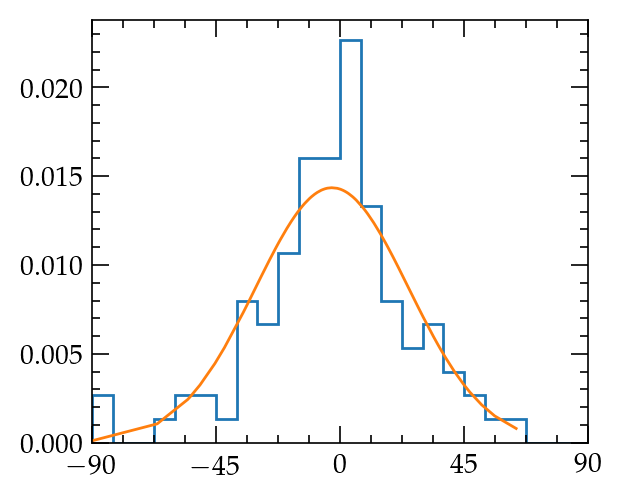

In [41]:
test = (
    "/vols/build/cms/akd116/newest/Combine/Decays/CMSSW_10_2_13/src/"
    "CombineHarvester/HTTSMCPDecays18/output/"
    "14042020/cmb/125/higgsCombine.alpha.MultiDimFit.mH125.123456.root"
)
f = uproot.open(test)["limit"]
df = f.pandas.df(["alpha","deltaNLL","quantileExpected"],
    namedecode="utf-8")
df = df.sort_values(by="alpha")

fig, ax = plt.subplots(
    figsize=(3.2, 2.8), dpi=200,
)
low_edges = np.linspace(-90, 90, num=25)
print(low_edges)
ax.hist(df["alpha"], bins=low_edges, histtype='step', density=True)

mean, std = norm.fit(df["alpha"])
print(mean, std)
p = norm.pdf(df["alpha"], mean, std)
plt.plot(df["alpha"], p, linewidth=1)
print(f"Fit results: {mean},  {std}")

ax.set_xticks([-90, -45, 0, 45, 90])
ax.set_xlim(-90., 90)
ax.set_ylim(0., None)